In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 5.1 MB/s eta 0:00:00


In [2]:
#Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV ,StratifiedKFold, HalvingGridSearchCV
from sklearn.metrics import accuracy_score, f1_score
from imblearn.over_sampling import SMOTENC
from sklearn.inspection import permutation_importance
import shap
#from sklearn.compose import TransformedTargetRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier


In [3]:
def Get_Data():
  df_xray = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/xray.pkl")
  df_clinical = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/clinical.pkl")
  df_mri = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/mri.pkl")
  df_questionnaires = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/questionnaires.pkl")
  df_tomography = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/tomography.pkl")
  df_biomarkers = pd.read_pickle("/content/drive/MyDrive/Dissertation Final/processed/biomarkers.pkl")
  df_progression = pd.read_csv('/content/drive/MyDrive/Dissertation Final/progression.csv')
  return(df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression)

In [4]:
df_xray,df_clinical,df_mri,df_questionnaires,df_tomography,df_biomarkers,df_progression = Get_Data()

In [5]:
df_xray.shape

(297, 24)

In [6]:
df_mri.shape

(297, 133)

In [7]:
(df_xray.isnull().sum().sum()/df_xray.size)*100

1.3187429854096522

In [8]:
(df_mri.isnull().sum().sum()/df_mri.size)*100

3.6556036556036555

In [9]:
df_progression

,ID,S,P
0,1,0,0
1,5,0,0
2,7,1,1
3,11,0,1
4,12,0,1
...,...,...,...
218,424,0,0
219,426,1,0
220,432,0,1
221,433,0,0


<Axes: xlabel='S', ylabel='count'>

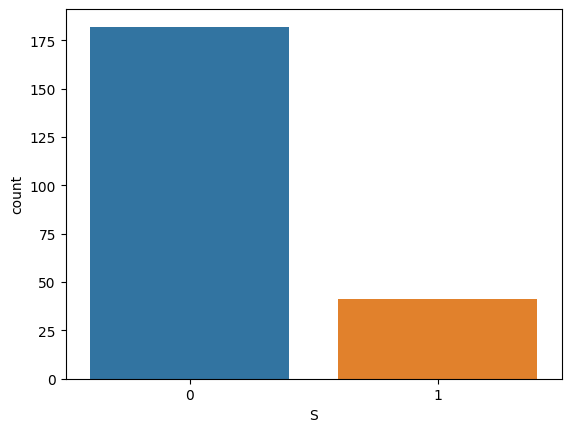

In [10]:
#Switch between 'S' and 'P' to see the class label distribution
sns.countplot(x=df_progression['S'])

In [11]:
df_progression['multiclass_labels'] = df_progression['P'] * 2 + df_progression['S']

In [12]:
df_progression

,ID,S,P,multiclass_labels
0,1,0,0,0
1,5,0,0,0
2,7,1,1,3
3,11,0,1,2
4,12,0,1,2
...,...,...,...,...
218,424,0,0,0
219,426,1,0,1
220,432,0,1,2
221,433,0,0,0


In [13]:
df_progression = df_progression.drop(['S','P'],axis =1)

In [14]:
df_progression, df_progression.shape


(      ID  multiclass_labels
 0      1                  0
 1      5                  0
 2      7                  3
 3     11                  2
 4     12                  2
 ..   ...                ...
 218  424                  0
 219  426                  1
 220  432                  2
 221  433                  0
 222  434                  3
 
 [223 rows x 2 columns],
 (223, 2))

In [15]:
df_progression['multiclass_labels'].value_counts()

0    115
2     67
1     30
3     11
Name: multiclass_labels, dtype: int64

In [16]:
def Join_DataSets(df1,df2):
  return(df1.join(df2))

In [17]:
joined_df = Join_DataSets(df_xray, df_clinical)

In [18]:
joined_df = Join_DataSets(joined_df,df_mri)

In [19]:
joined_df = Join_DataSets(joined_df,df_biomarkers)

In [20]:
joined_df.shape

(297, 211)

In [21]:
id_sub = df_xray.index
output = {n: int(str(n)[-3:]) for n in id_sub}

In [22]:
dic_reversed = {v: k for k, v in output.items()}
df_progression['Key'] = df_progression['ID'].map(dic_reversed)
df_progression['Key'] = df_progression['Key'].replace({np.nan: 'NaN'})

In [23]:
df_progression = df_progression.drop(['ID'],axis =1)

In [24]:
merged_df = pd.merge(df_progression, joined_df , left_on='Key', right_on='Subject ID')

In [25]:
merged_df = merged_df.drop(['Key'],axis =1)

#**Exploratory Data Analysis**

In [26]:
merged_df.shape

(223, 212)

In [27]:
merged_df['multiclass_labels'].value_counts()

0    115
2     67
1     30
3     11
Name: multiclass_labels, dtype: int64

<Axes: xlabel='multiclass_labels', ylabel='count'>

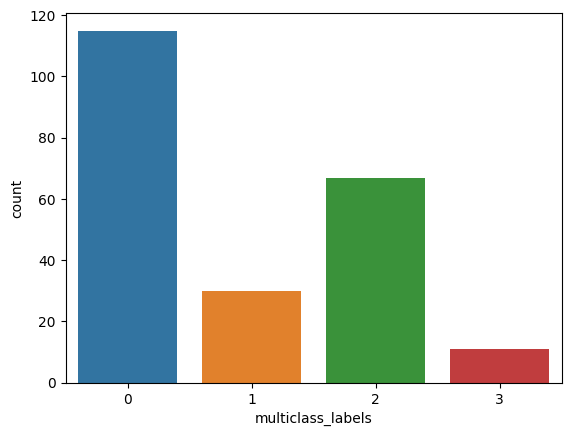

In [28]:
sns.countplot(x=merged_df['multiclass_labels'])

In [29]:
merged_df.isnull().sum()

multiclass_labels       0
Density_Mean_Femur_K    0
Density_Mean_Tibia_K    0
Femorotibial_Angle_K    0
JSW_Mean_K              0
                       ..
S_C2M                   2
S_RE_C1M                2
S_C10C                  2
S_COLL2_1               2
S_COLL2_1NO2            2
Length: 212, dtype: int64

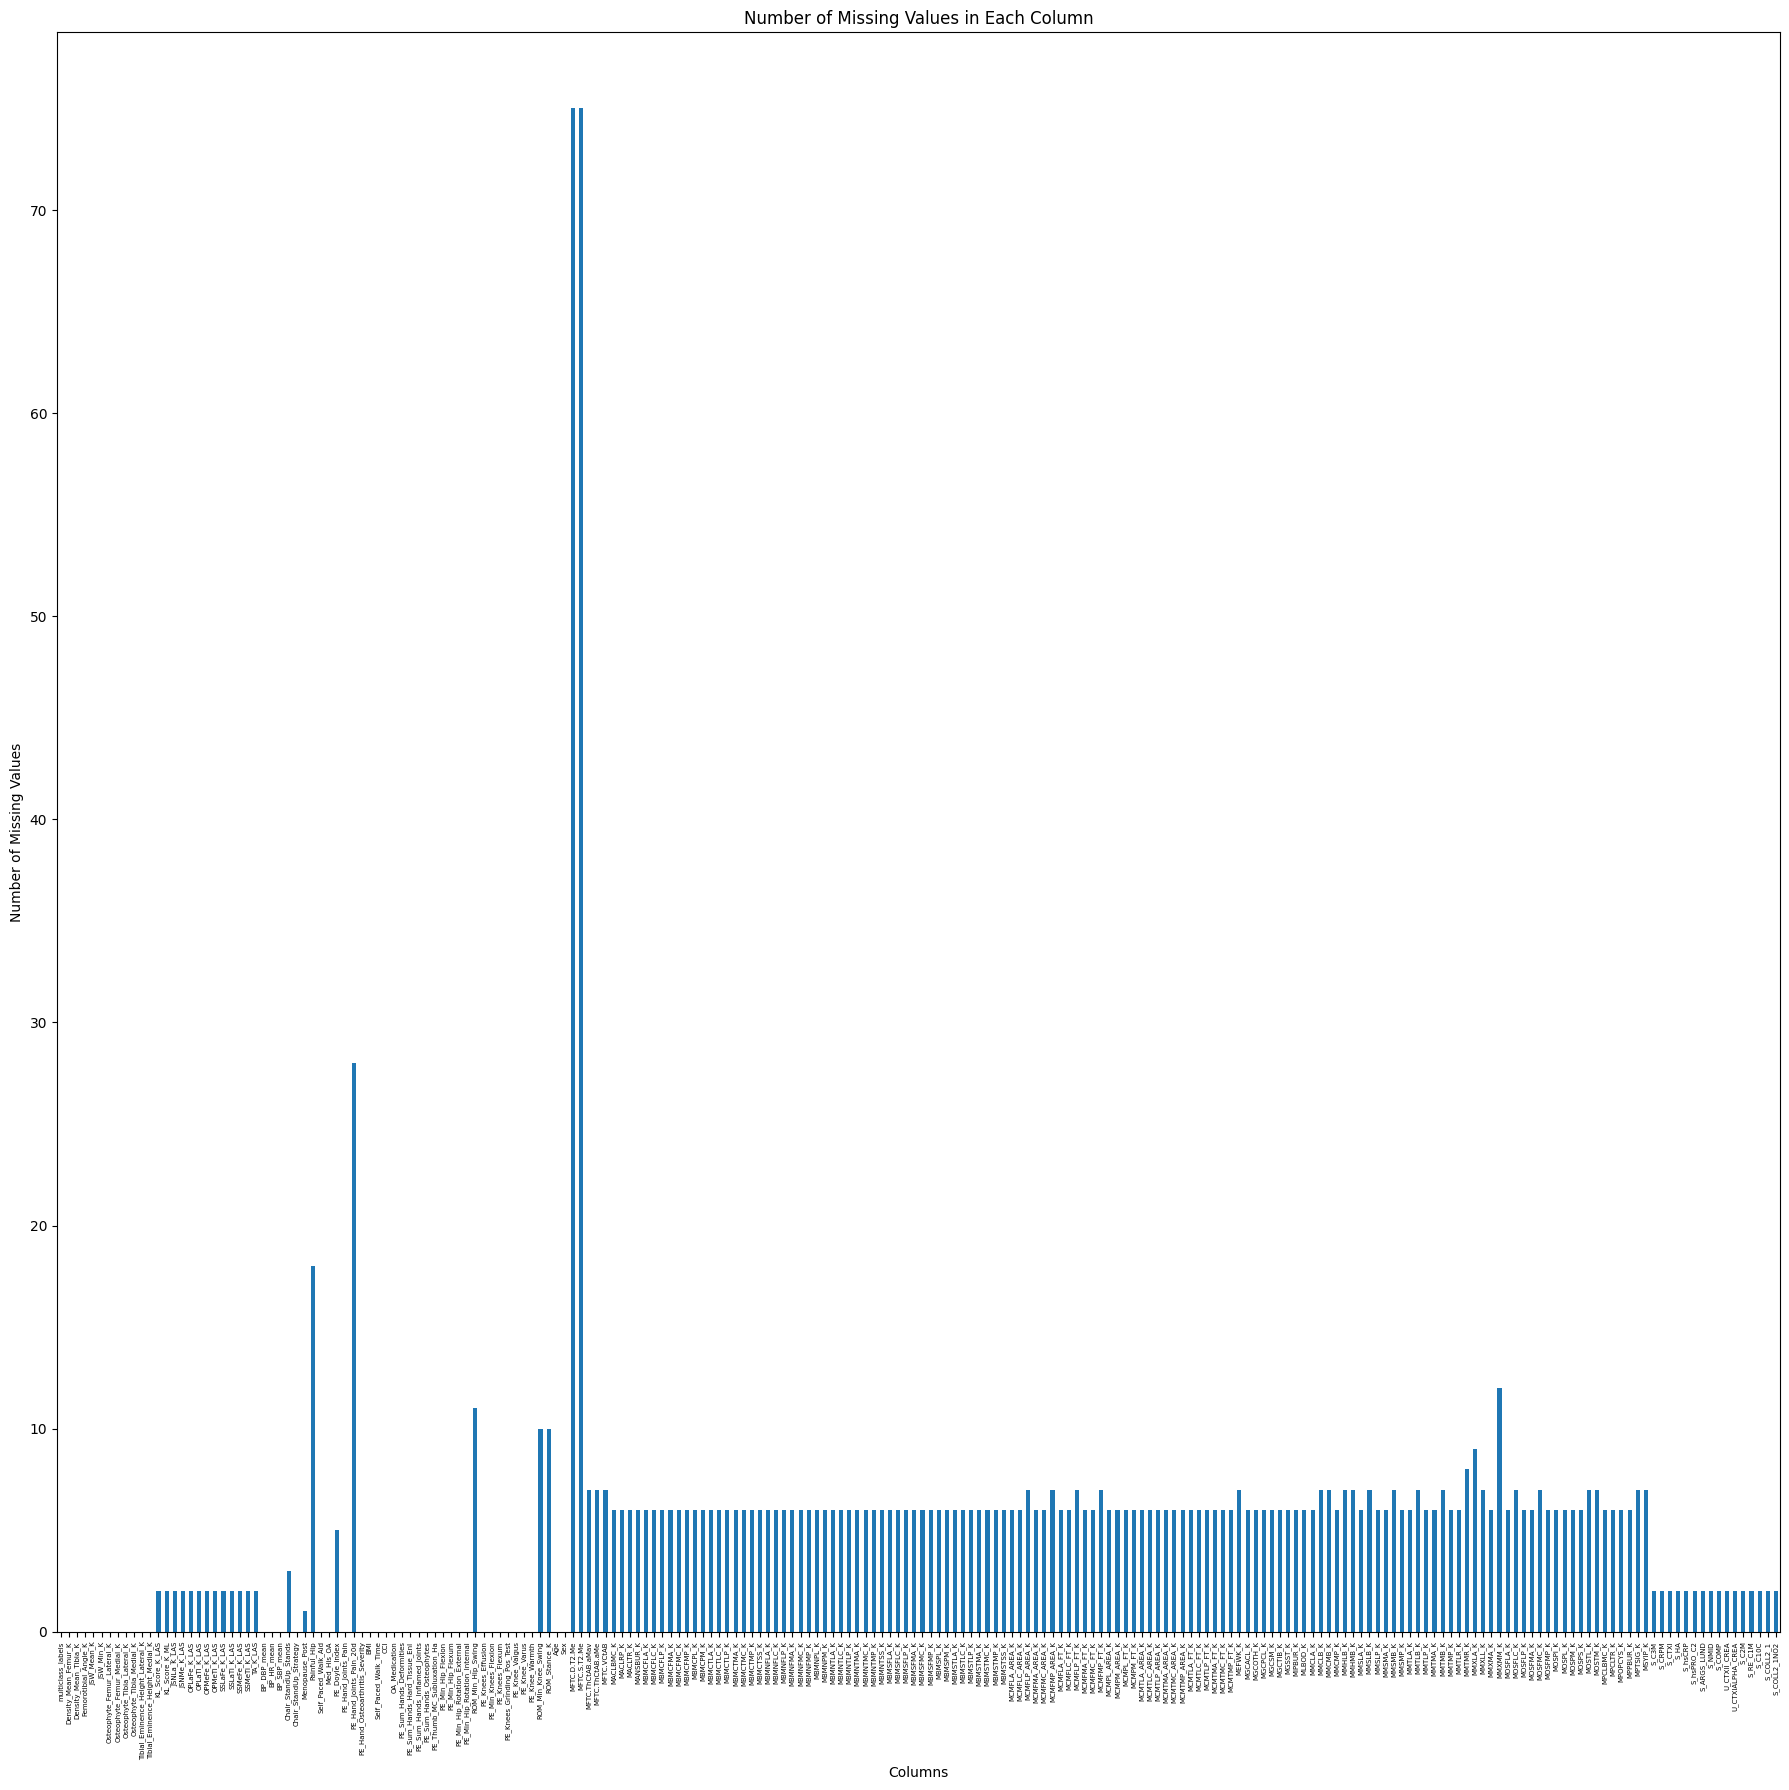

In [30]:
plt.figure(figsize=(18, 18))
merged_df.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

In [31]:
numerical_count = merged_df.select_dtypes(include=['int', 'float']).shape[1]
categorical_count = merged_df.select_dtypes(include=['object', 'category']).shape[1]

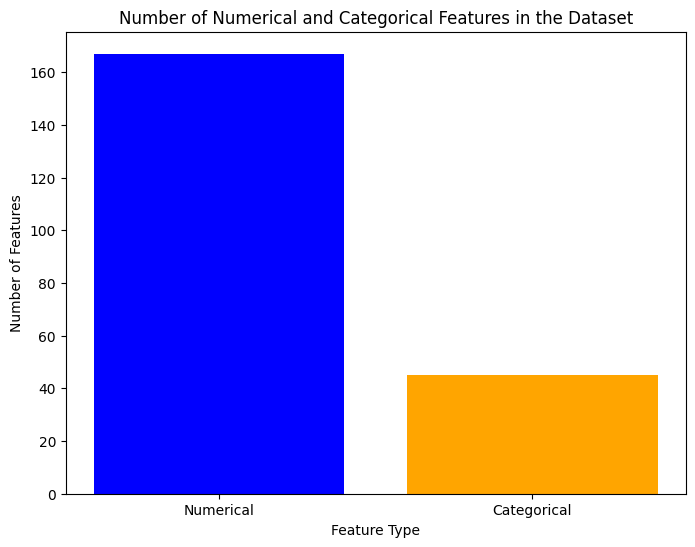

In [32]:
plt.figure(figsize=(8, 6))
plt.bar(['Numerical', 'Categorical'], [numerical_count, categorical_count], color=['blue', 'orange'])
plt.xlabel('Feature Type')
plt.ylabel('Number of Features')
plt.title('Number of Numerical and Categorical Features in the Dataset')
plt.show()

<Axes: >

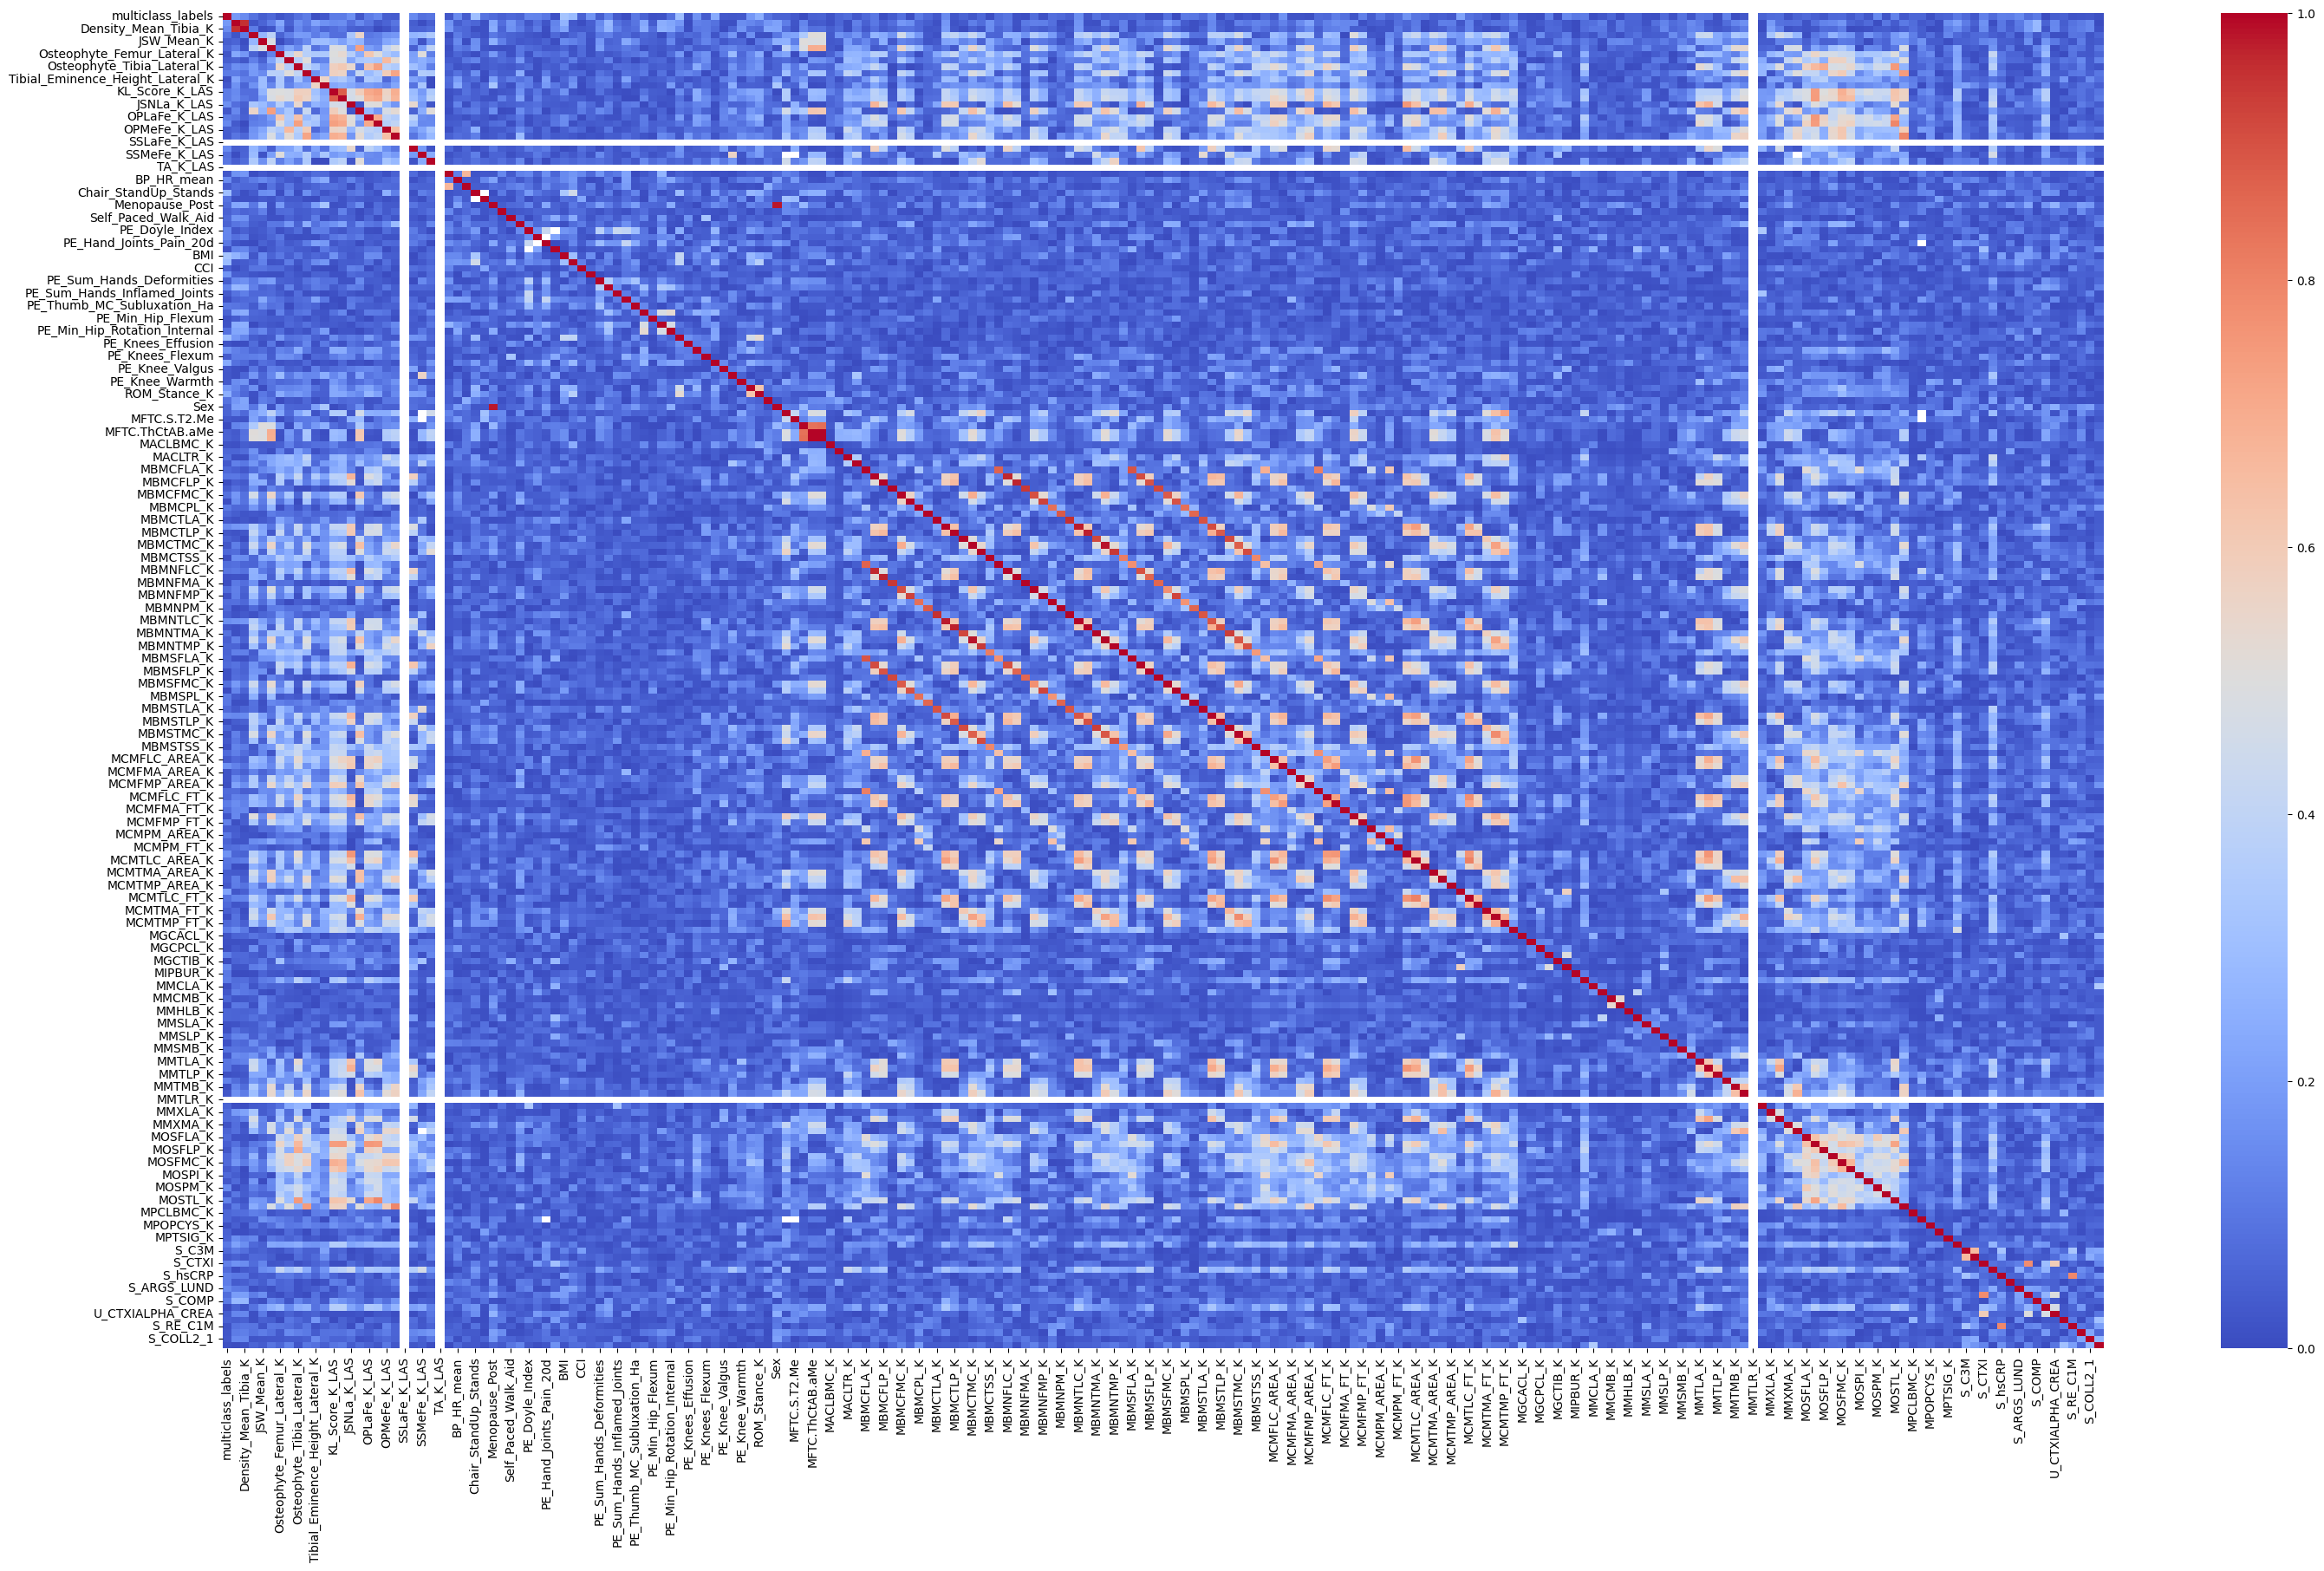

In [33]:
correlation_heatmap = merged_df.astype(float).corr().abs()
plt.figure(figsize = (35,20))
sns.heatmap(correlation_heatmap,annot=False,cmap = 'coolwarm')

In [34]:
summary_stats = merged_df.describe()
summary_stats

,multiclass_labels,Density_Mean_Femur_K,Density_Mean_Tibia_K,Femorotibial_Angle_K,JSW_Mean_K,JSW_Min_K,Osteophyte_Femur_Lateral_K,Osteophyte_Femur_Medial_K,Osteophyte_Tibia_Lateral_K,Osteophyte_Tibia_Medial_K,...,S_ARGS_LUND,S_NMID,S_COMP,U_CTXII_CREA,U_CTXIALPHA_CREA,S_C2M,S_RE_C1M,S_C10C,S_COLL2_1,S_COLL2_1NO2
count,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,223.000000,...,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000,221.000000
mean,0.883408,29.857848,31.646278,-3.543857,5.508341,2.570090,4.749955,3.172152,7.298161,4.685605,...,0.163394,22.029502,13.595928,368.572851,0.771041,0.350226,37.905882,3778.915385,916.434389,890.867873
std,1.002179,4.801931,5.270543,2.653077,0.962744,1.222923,5.371000,6.076005,9.622534,4.673542,...,0.046659,7.772594,4.103284,243.975140,0.609227,0.107574,20.105013,815.232981,218.753704,694.024355
min,0.000000,20.100000,20.100000,-11.790000,3.110000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.070000,6.440000,5.100000,40.000000,0.100000,0.130000,23.600000,1508.300000,495.000000,196.000000
25%,0.000000,25.965000,27.805000,-5.315000,4.805000,1.875000,0.000000,0.000000,1.995000,1.560000,...,0.140000,16.710000,10.800000,218.000000,0.400000,0.290000,25.700000,3279.300000,780.000000,546.000000
50%,0.000000,29.300000,31.060000,-3.300000,5.410000,2.740000,3.810000,0.000000,4.140000,3.490000,...,0.160000,20.960000,13.000000,312.000000,0.600000,0.330000,31.800000,3739.500000,879.000000,715.000000
75%,2.000000,33.515000,35.115000,-1.845000,6.190000,3.505000,7.020000,4.835000,8.380000,6.275000,...,0.180000,27.140000,15.700000,443.000000,1.000000,0.380000,40.800000,4241.400000,1040.000000,967.000000
max,3.000000,43.250000,47.550000,3.210000,8.140000,5.390000,34.710000,45.400000,72.960000,26.940000,...,0.550000,51.790000,30.500000,2264.000000,4.800000,1.040000,140.400000,7076.100000,1993.000000,5995.000000


#**Pre-processing**

In [35]:
merged_df.dropna(axis=1, thresh=0.6 * merged_df.shape[0], inplace=True)
merged_df = merged_df.loc[:, merged_df.apply(lambda column: column.nunique() > 1)]

In [36]:
merged_df.shape

(223, 209)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(merged_df.drop(columns=['multiclass_labels']),merged_df['multiclass_labels'],test_size = 0.2)

In [38]:
X_train_column_names = X_train.columns.tolist()
X_train_numerical_features = X_train.select_dtypes(include=['int', 'float']).columns.tolist()
X_train_categorical_features = X_train.select_dtypes(include=['category']).columns.tolist()


In [39]:
X_train_categorical_feature_indices = [X_train.columns.get_loc(col) for col in X_train_categorical_features]

In [40]:
X_train.isnull().sum().sum(), X_test.isnull().sum().sum()

(887, 217)

In [41]:
numeric_transformer = Pipeline(
    steps=[("imputer", KNNImputer()), ("scaler", MinMaxScaler())]
)
categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, X_train_numerical_features),
        ("cat", categorical_transformer, X_train_categorical_features),
    ]
)

In [42]:
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

In [43]:
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns = X_train_column_names )
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, columns = X_train_column_names)

In [44]:
X_train_preprocessed.isnull().sum().sum(), X_test_preprocessed.isnull().sum().sum()

(0, 0)

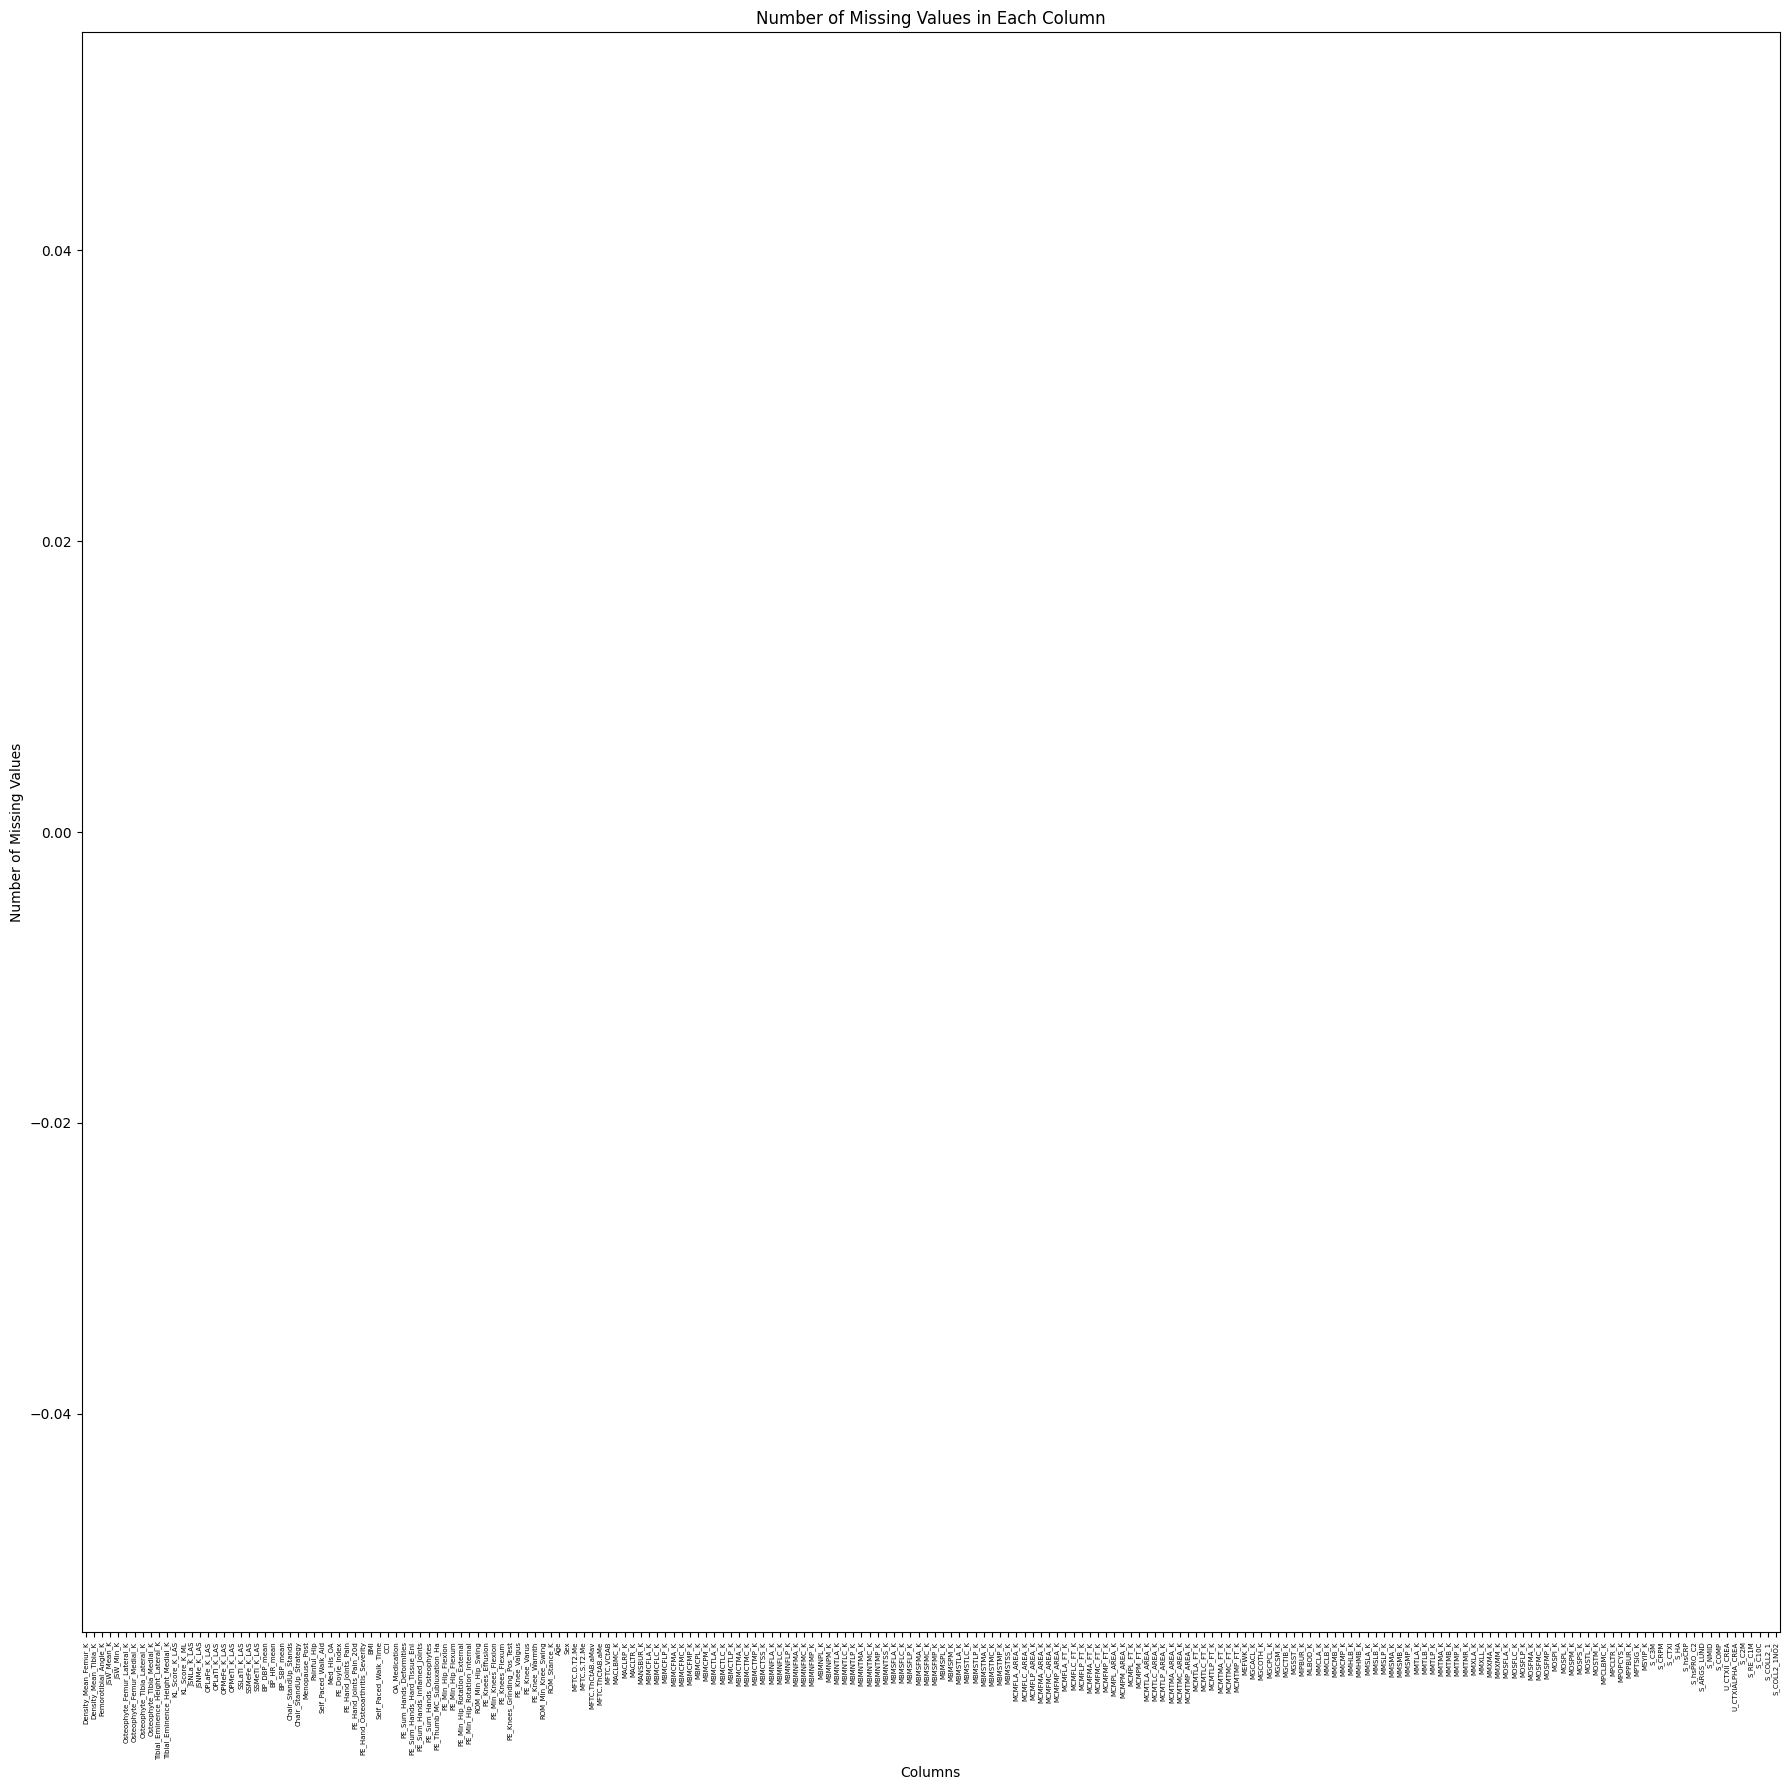

In [45]:
plt.figure(figsize=(18, 18))
X_test_preprocessed.isnull().sum().plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Number of Missing Values')
plt.title('Number of Missing Values in Each Column')
plt.xticks(rotation = 90, fontsize=5)
plt.tight_layout()
plt.show()

#**Oversampling**

In [46]:
y_train.value_counts()

0    87
2    61
1    21
3     9
Name: multiclass_labels, dtype: int64

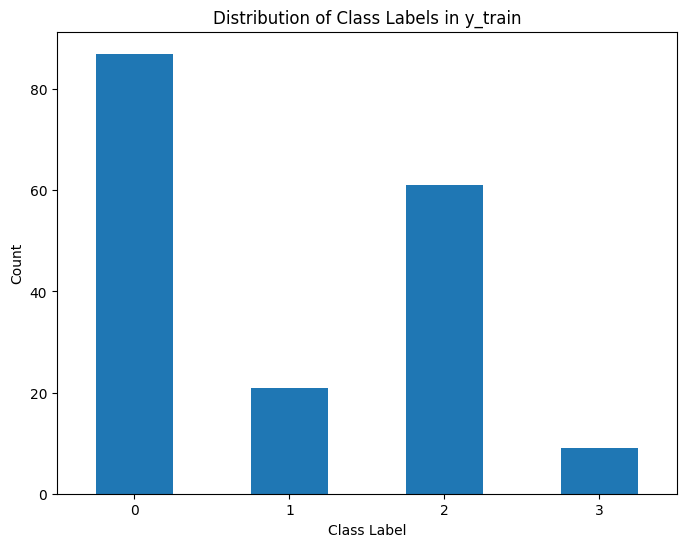

In [47]:
plt.figure(figsize=(8, 6))
y_train.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

In [48]:
oversample = SMOTENC(categorical_features=X_train_categorical_feature_indices, random_state=42)
X_train_preprocessed_balanced, y_train_balanced = oversample.fit_resample(X_train_preprocessed, y_train)


In [49]:
y_train_balanced.value_counts()

2    87
0    87
1    87
3    87
Name: multiclass_labels, dtype: int64

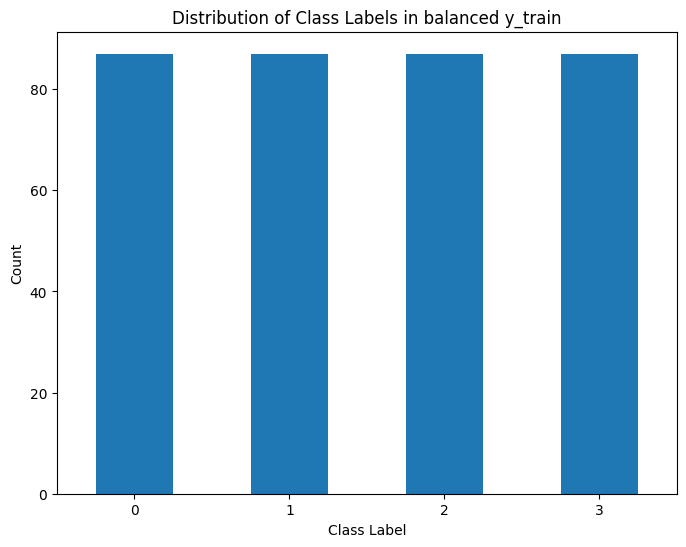

In [50]:
plt.figure(figsize=(8, 6))
y_train_balanced.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Class Labels in balanced y_train')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

#**One hot encoding**

In [51]:
def perform_one_hot_encoding(data1,data2, categorical_columns):
  encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
  encoded_columns1 = encoder.fit_transform(data1[categorical_columns])
  encoded_columns2 = encoder.transform(data2[categorical_columns])
  encoded_data1 = pd.DataFrame(encoded_columns1, columns=encoder.get_feature_names_out(categorical_columns))
  encoded_data2 = pd.DataFrame(encoded_columns2, columns=encoder.get_feature_names_out(categorical_columns))
  print(encoded_data1.shape)
  data1 = data1.drop(columns=categorical_columns)
  data2 = data2.drop(columns=categorical_columns)
  data1 = pd.concat([data1, encoded_data1], axis=1)
  data2 = pd.concat([data2, encoded_data2], axis=1)
  return data1,data2

In [52]:
X_train_preprocessed_balanced_encoded, X_test_preprocessed_encoded = perform_one_hot_encoding(X_train_preprocessed_balanced,X_test_preprocessed, X_train_categorical_features)


(348, 1631)


In [53]:
X_train_preprocessed_balanced_encoded.shape, X_test_preprocessed_encoded.shape

((348, 1797), (45, 1797))

# **Feature selection using correlation**

In [54]:
def highly_correlated(df):
  correlations = df.astype(float).corr().abs()
  mask = np.triu(np.ones(correlations.shape), k=1).astype(bool)
  correlations.where(mask, inplace=True)
  print("Correlation Matrix:")
  print(correlations)
  columns_to_drop = [i for i in correlations if any(abs(correlations[i]) >= 0.7)]
  df.drop(columns=columns_to_drop, inplace=True)
  plt.figure(figsize = (35,20))
  sns.heatmap(correlations,annot=False,cmap = 'coolwarm')
  return(df)

In [55]:
X_train_preprocessed_balanced_encoded_corr = highly_correlated(X_train_preprocessed_balanced_encoded)

Output hidden; open in https://colab.research.google.com to view.

<Axes: >

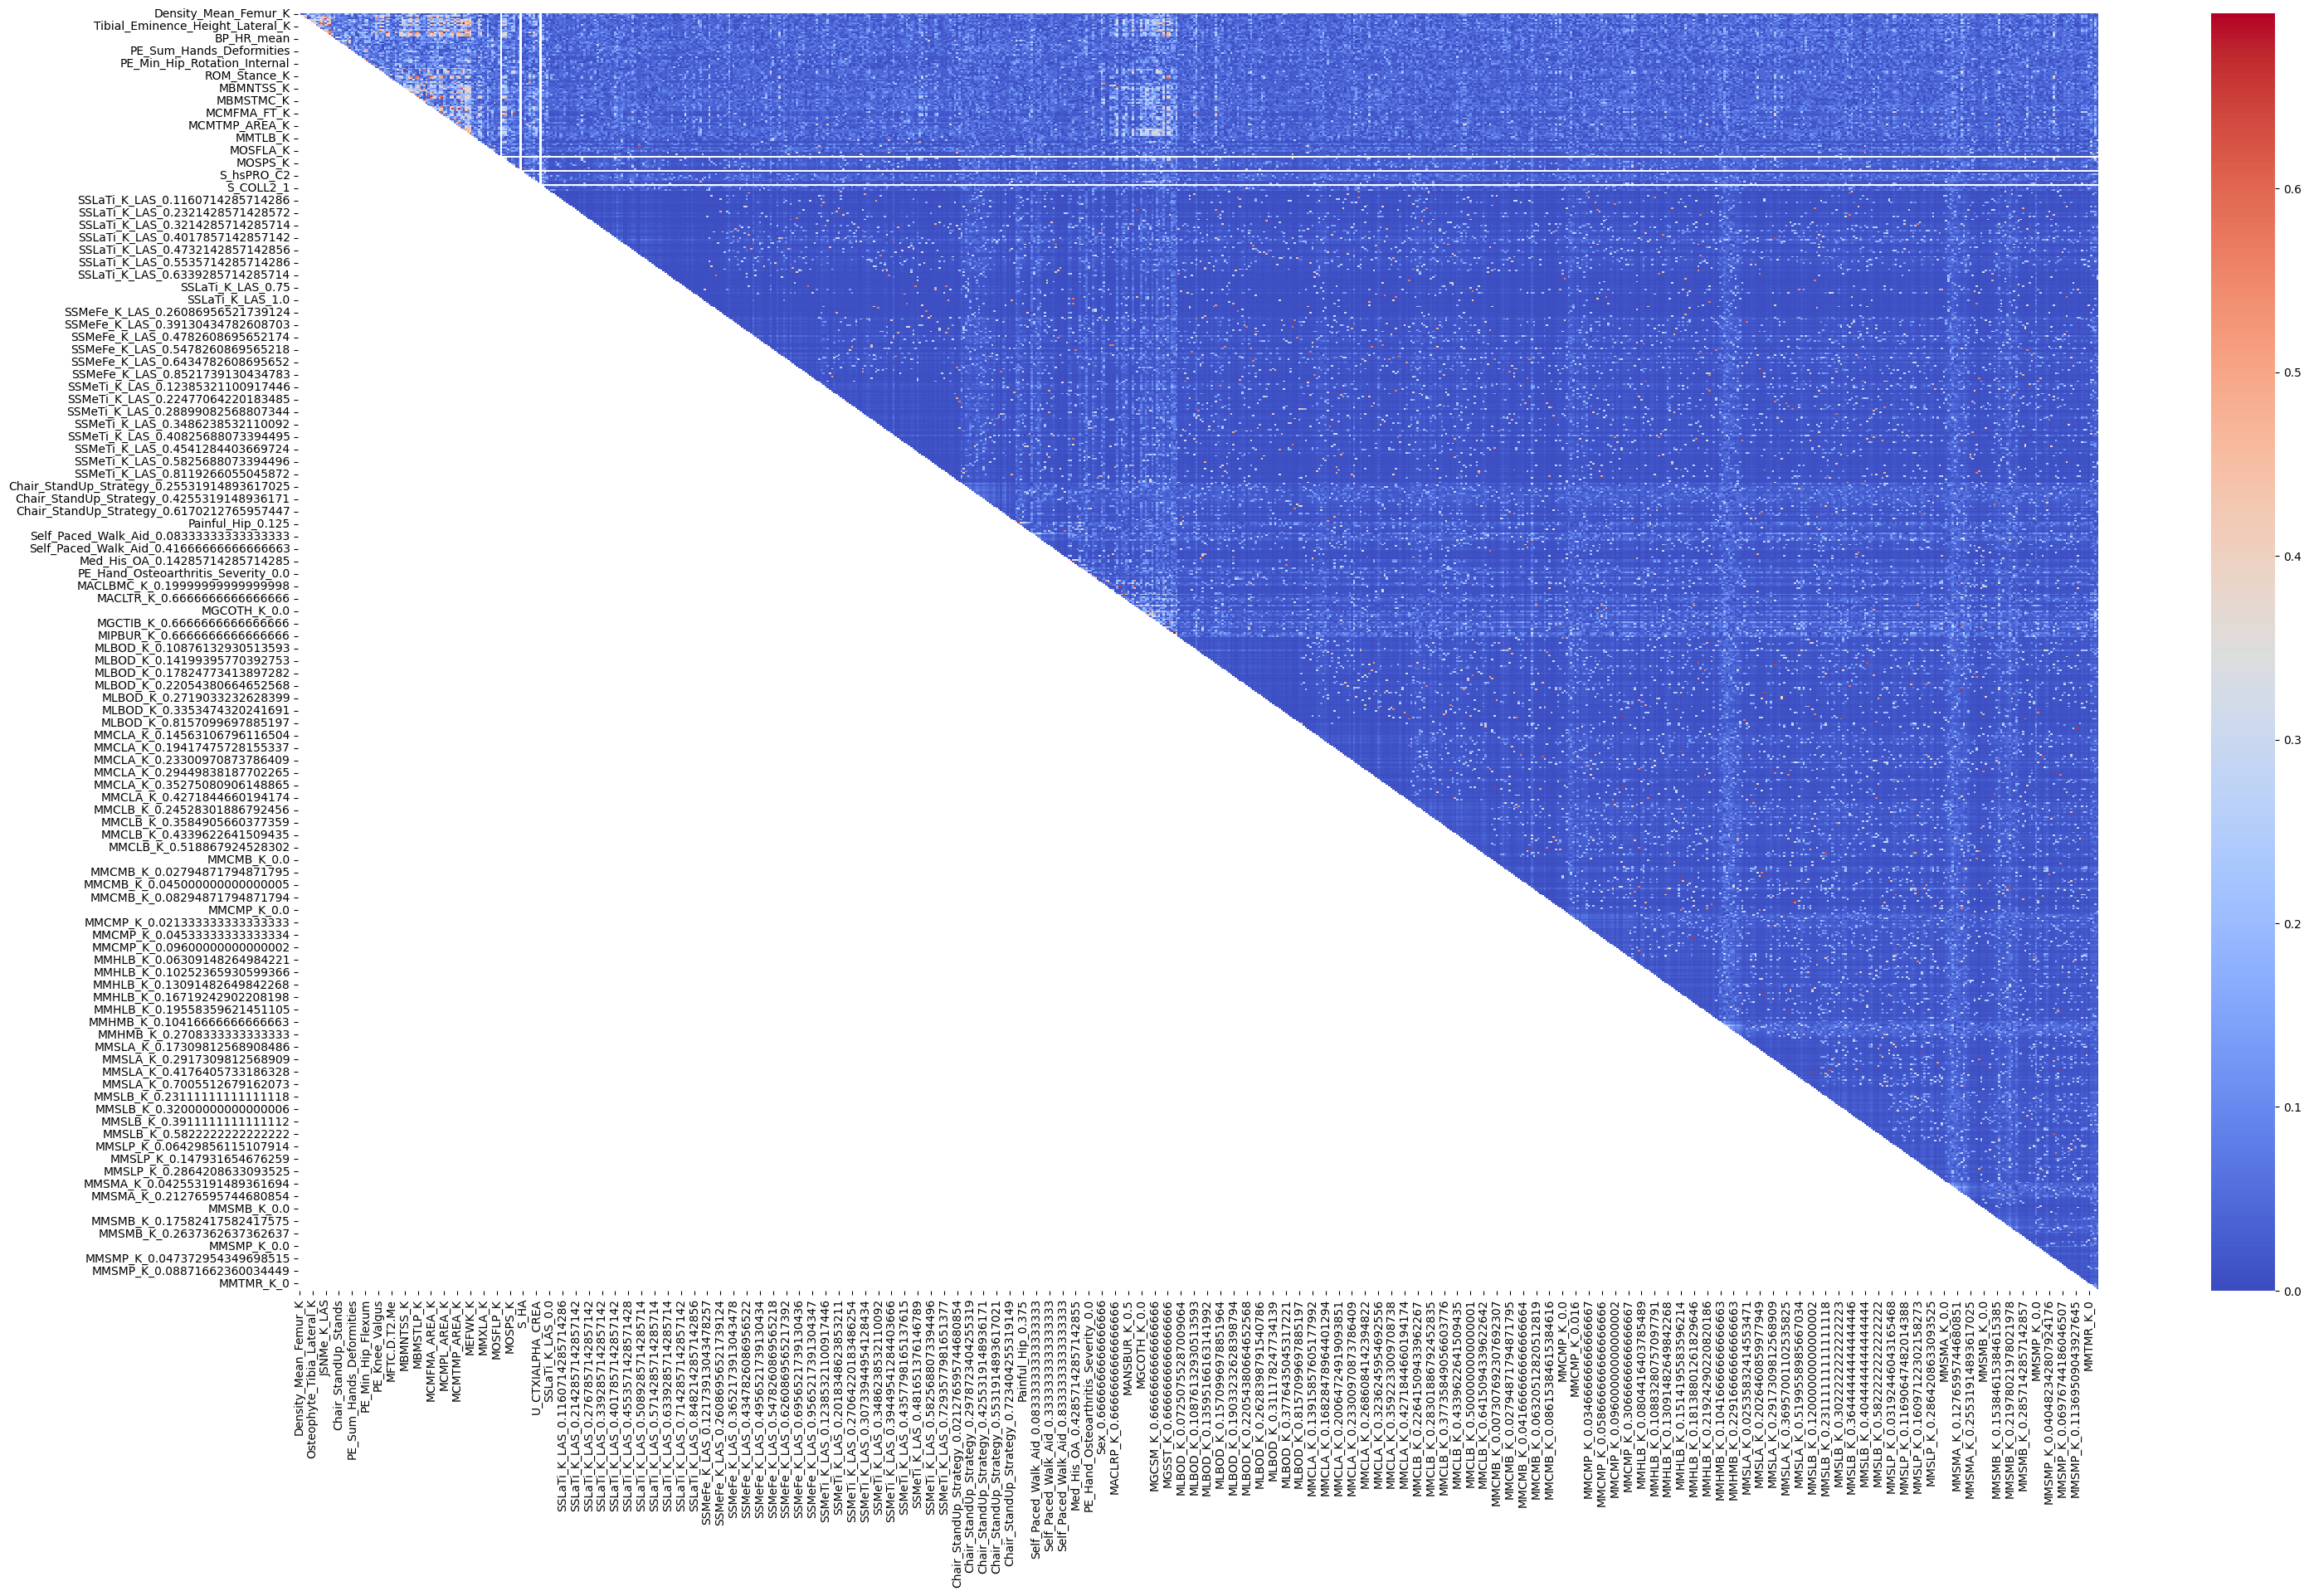

In [56]:
correlation_new = X_train_preprocessed_balanced_encoded_corr.astype(float).corr().abs()
mask = np.triu(np.ones(correlation_new.shape), k=1).astype(bool)
correlation_new.where(mask, inplace=True)
plt.figure(figsize = (35,20))
sns.heatmap(correlation_new,annot=False,cmap = 'coolwarm')

In [57]:
X_train_preprocessed_balanced_encoded_corr.shape

(348, 821)

In [58]:
column_names_final  = X_train_preprocessed_balanced_encoded_corr.columns.tolist()

In [59]:
X_test_preprocessed_encoded_corr = X_test_preprocessed_encoded[column_names_final]

In [60]:
X_train_preprocessed_balanced_encoded_corr.shape,X_test_preprocessed_encoded_corr.shape,y_train_balanced.shape,y_test.shape

((348, 821), (45, 821), (348,), (45,))

**Machine Learning Pipeline**

In [61]:
def knnModel(X_train, X_test, y_train, y_test):
  knn_clf = KNeighborsClassifier()
  inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
  knn_param_grid = {'n_neighbors': [3, 5, 7,11,15,20]}
  knn_search = HalvingGridSearchCV(knn_clf, knn_param_grid, cv=inner_cv)
  knn_search.fit(X_train, y_train)
  knn_pred = knn_search.predict(X_test)
  knn_accuracy = accuracy_score(y_test, knn_pred)
  knn_f1_macro = f1_score(y_test, knn_pred, average='macro')
  selected_features_list = []

  perm_importance = permutation_importance(knn_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
  feature_importances = perm_importance.importances_mean
  num_features_to_select = 5
  important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
  selected_features = X_train.columns[important_feature_indices]
  selected_features_list.append(selected_features)
  X_train_selected = X_train[selected_features]
  X_test_selected = X_test[selected_features]
  clf_selected = knn_search.best_estimator_
  clf_selected.fit(X_train_selected, y_train)
  results_df = pd.DataFrame({
        'Classifier': "KNN",
        'Accuracy': knn_accuracy,
        'F1 Score Macro': knn_f1_macro,
        'Best Params': knn_search.best_params_
  })
  explainer_knn = shap.KernelExplainer(clf_selected.predict, X_train_selected)
  shap_values_knn = explainer_knn.shap_values(X_test_selected)
  shap.summary_plot(shap_values_knn, X_test_selected, feature_names=X_test_selected.columns)
  return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

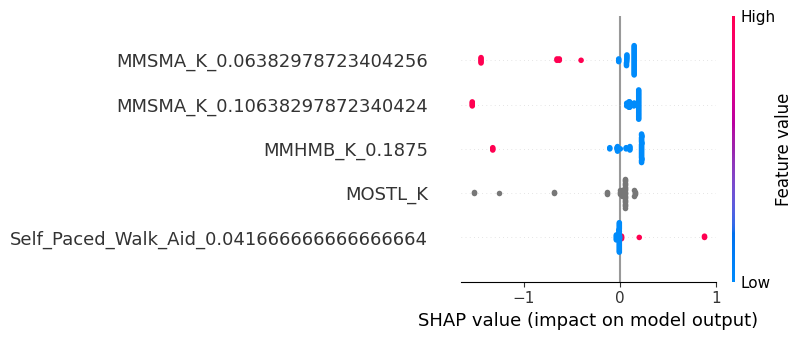

(            Classifier  Accuracy  F1 Score Macro  Best Params
 n_neighbors        KNN  0.288889        0.118182            3,
 [Index(['MMHMB_K_0.1875', 'MOSTL_K', 'Self_Paced_Walk_Aid_0.041666666666666664',
         'MMSMA_K_0.06382978723404256', 'MMSMA_K_0.10638297872340424'],
        dtype='object')])

In [62]:
knnModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)

In [63]:
def randomForestModel(X_train, X_test, y_train, y_test):
    rf_clf = RandomForestClassifier()
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    rf_param_grid = {'n_estimators': [100, 200, 300, 400, 500], 'max_depth': [None, 10, 20, 30, 40, 50]}
    rf_search = HalvingGridSearchCV(rf_clf, rf_param_grid, cv=inner_cv)
    rf_search.fit(X_train, y_train)
    rf_pred = rf_search.predict(X_test)
    rf_accuracy = accuracy_score(y_test, rf_pred)
    rf_f1_macro = f1_score(y_test, rf_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(rf_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = rf_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Random Forest",
        'Accuracy': rf_accuracy,
        'F1 Score Macro': rf_f1_macro,
        'Best Params': [rf_search.best_params_]
    })

    explainer_rf = shap.TreeExplainer(clf_selected)
    shap_values_rf = explainer_rf.shap_values(X_test_selected)
    shap.summary_plot(shap_values_rf[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list




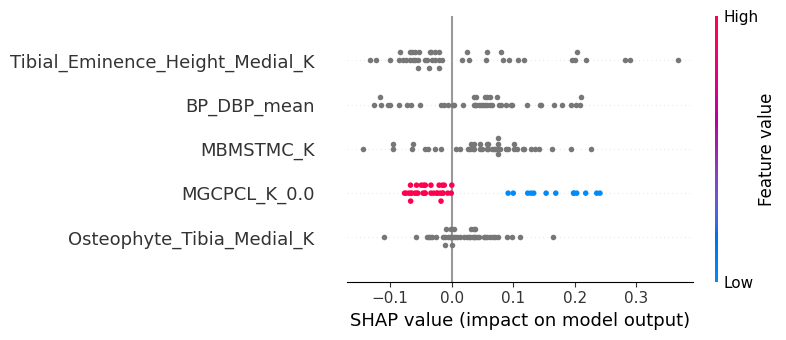

(      Classifier  Accuracy  F1 Score Macro  \
0  Random Forest  0.533333        0.297414   

                              Best Params  
0  {'max_depth': 20, 'n_estimators': 500}  , [Index(['Osteophyte_Tibia_Medial_K', 'BP_DBP_mean',
       'Tibial_Eminence_Height_Medial_K', 'MGCPCL_K_0.0', 'MBMSTMC_K'],
      dtype='object')])


In [64]:
results = randomForestModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [65]:
def annModel(X_train, X_test, y_train, y_test):
    ann_clf = MLPClassifier(max_iter=1000)
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    ann_param_grid = {'hidden_layer_sizes': [(100,), (50, 50), (30, 30, 30)]}
    ann_search = HalvingGridSearchCV(ann_clf, ann_param_grid, cv=inner_cv)
    ann_search.fit(X_train, y_train)
    ann_pred = ann_search.predict(X_test)
    ann_accuracy = accuracy_score(y_test, ann_pred)
    ann_f1_macro = f1_score(y_test, ann_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(ann_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = ann_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Artificial Neural Network",
        'Accuracy': ann_accuracy,
        'F1 Score Macro': ann_f1_macro,
        'Best Params': [ann_search.best_params_]
    })

    explainer_ann = shap.KernelExplainer(clf_selected.predict_proba, X_train_selected)
    shap_values_ann = explainer_ann.shap_values(X_test_selected)
    shap.summary_plot(shap_values_ann, X_test_selected, feature_names=X_test_selected.columns)

    return results_df,selected_features_list

  0%|          | 0/45 [00:00<?, ?it/s]

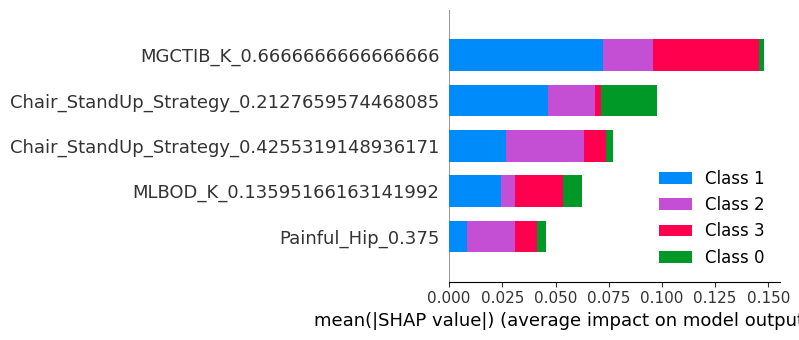

(                  Classifier  Accuracy  F1 Score Macro  \
0  Artificial Neural Network  0.422222        0.249359   

                      Best Params  
0  {'hidden_layer_sizes': (100,)}  , [Index(['MLBOD_K_0.13595166163141992', 'MGCTIB_K_0.6666666666666666',
       'Chair_StandUp_Strategy_0.4255319148936171', 'Painful_Hip_0.375',
       'Chair_StandUp_Strategy_0.2127659574468085'],
      dtype='object')])


In [66]:
results = annModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)

In [67]:
def decisionTreeModel(X_train, X_test, y_train, y_test):
    dt_clf = DecisionTreeClassifier(max_depth=10)  # You can adjust max_depth as needed
    inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    dt_param_grid = {'max_depth': [None, 10, 20, 30, 40, 50]}
    dt_search = HalvingGridSearchCV(dt_clf, dt_param_grid, cv=inner_cv)
    dt_search.fit(X_train, y_train)
    dt_pred = dt_search.predict(X_test)
    dt_accuracy = accuracy_score(y_test, dt_pred)
    dt_f1_macro = f1_score(y_test, dt_pred, average='macro')

    selected_features_list = []

    # Permutation importance for feature selection
    perm_importance = permutation_importance(dt_search.best_estimator_, X_test, y_test, n_repeats=30, random_state=42)
    feature_importances = perm_importance.importances_mean
    num_features_to_select = 5
    important_feature_indices = feature_importances.argsort()[-num_features_to_select:][::-1]
    selected_features = X_train.columns[important_feature_indices]
    selected_features_list.append(selected_features)

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    clf_selected = dt_search.best_estimator_
    clf_selected.fit(X_train_selected, y_train)

    results_df = pd.DataFrame({
        'Classifier': "Decision Tree",
        'Accuracy': dt_accuracy,
        'F1 Score Macro': dt_f1_macro,
        'Best Params': [dt_search.best_params_]
    })

    explainer_dt = shap.TreeExplainer(clf_selected)
    shap_values_dt = explainer_dt.shap_values(X_test_selected)
    shap.summary_plot(shap_values_dt[0], X_test_selected, feature_names=X_test_selected.columns)

    return results_df, selected_features_list

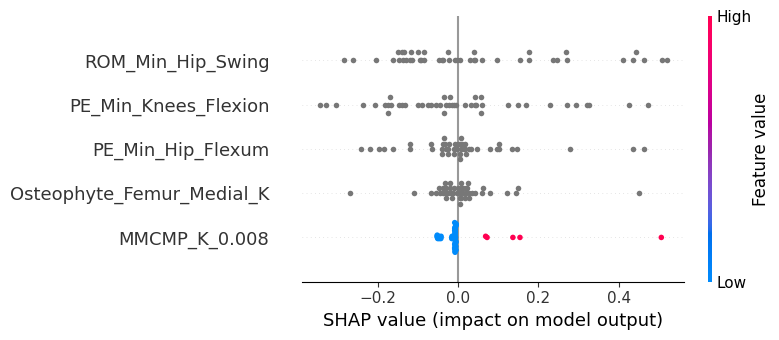

(      Classifier  Accuracy  F1 Score Macro          Best Params
0  Decision Tree  0.244444        0.141279  {'max_depth': None}, [Index(['ROM_Min_Hip_Swing', 'Osteophyte_Femur_Medial_K', 'MMCMP_K_0.008',
       'PE_Min_Hip_Flexum', 'PE_Min_Knees_Flexion'],
      dtype='object')])


In [68]:
results = decisionTreeModel(X_train_preprocessed_balanced_encoded_corr,X_test_preprocessed_encoded_corr , y_train_balanced, y_test)
print(results)